In [135]:
import numpy as np
import matplotlib.pyplot as plt
import colossus
from colossus.cosmology import cosmology
from colossus.halo import concentration, mass_so, profile_nfw
from plotter import plot, loglogplot
from scipy.interpolate import InterpolatedUnivariateSpline as interp
from astropy.cosmology import FlatLambdaCDM, z_at_value
import astropy.units as u
import subprocess
from os import getcwd
from os.path import isfile
import warnings
from pathlib import Path
from os.path import expanduser
%matplotlib inline

In [21]:
home_dir = Path(expanduser('~'))
multimah_root = home_dir / 'frank_mah/output'

In [2]:
# will need to test sensitivity to:
# 1. c(M,z) relationship: Zhao+09, Duffy+08, Diemer+19
# 2. MAH model: Zhao+09, vdB+14, Parkinson+08 merger trees
# 3. Various cosmologies

In [5]:
# global variables
# free parameters of Shi+14 model; can be changed later
beta_def = 1.0
eta_def  = 0.7

G = colossus.utils.constants.G
cm_per_km = 1e5
km_per_kpc = colossus.utils.constants.KPC / cm_per_km # KPC was in cm
s_per_Gyr = colossus.utils.constants.GYR
yr_per_Gyr = 1E9

# can reset cosmology on-the-fly, will start with WMAP 5
cosmo = cosmology.setCosmology('WMAP5')
cosmo_astro = FlatLambdaCDM(H0=cosmology.getCurrent().H0 * u.km / u.s / u.Mpc, Tcmb0=cosmology.getCurrent().Tcmb0 * u.K, Om0=cosmology.getCurrent().Om0, Neff=cosmology.getCurrent().Neff, Ob0=cosmology.getCurrent().Ob0)

# adding a modified EdS
eds_params = cosmology.cosmologies['EdS']
#eds_params['Om0'] = 0.99 # not sure why this isn't the solution...
eds_params['Ob0'] = 0.001
cosmology.addCosmology('near_EdS', eds_params)

# let's make some various cosmologies perturbed from planck18 fiducial
# we can go up and down in sigma_8
# then go up and down in omega_m
# then go up and down in h
fiducial_params = cosmology.cosmologies['planck18'].copy() # can always change the fiducial if we want
fiducial_params['Om0'] = 0.1
cosmology.addCosmology('pl18_lowOm0', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['Om0'] = 0.5
cosmology.addCosmology('pl18_hiOm0', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy() # reset to default
fiducial_params['sigma8'] = 0.5
cosmology.addCosmology('pl18_lows8', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['sigma8'] = 1.2
cosmology.addCosmology('pl18_his8', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy() # reset to default
fiducial_params['H0'] = 60
cosmology.addCosmology('pl18_lowH0', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['H0'] = 80
cosmology.addCosmology('pl18_hiH0', fiducial_params)

print(cosmology.getCurrent())

Cosmology "WMAP5" 
    flat = True, Om0 = 0.2732, Ode0 = 0.7267, Ob0 = 0.0456, H0 = 70.50, sigma8 = 0.8120, ns = 0.9600
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [6]:
# cosmologies to test the effect of varying S8 instead...
# S_8 = sigma_8 * sqrt(Omega_m / 0.3)

cosmology.setCosmology('planck18')

def S8_cosmo(cosmo):
    return cosmo.sigma8 * np.sqrt(cosmo.Om0 / 0.3)
print(S8_cosmo(cosmology.getCurrent()))

# so 0.825 is S8 for planck18
# we need to now vary this up and down by varying 

fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['sigma8'] = 1.0
fiducial_params['Om0'] = 0.3
cosmology.addCosmology('pl18_s8_1_1', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['sigma8'] = 0.8
fiducial_params['Om0'] = 0.469
cosmology.addCosmology('pl18_s8_1_2', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['sigma8'] = 0.6
fiducial_params['Om0'] = 0.3
cosmology.addCosmology('pl18_s8_p6_1', fiducial_params)
fiducial_params = cosmology.cosmologies['planck18'].copy()
fiducial_params['sigma8'] = 0.5
fiducial_params['Om0'] = 0.432
cosmology.addCosmology('pl18_s8_p6_2', fiducial_params)

# dictionary of names for different cosmologies
cosmo_dict = {'near_EdS': 'eeddss', 'WMAP5': 'WMAP05', 'planck18': 'plnk18', 
              'pl18_lowOm0': 'p8loOm', 'pl18_hiOm0': 'p8hiOm', 'pl18_lows8': 'p8los8',
              'pl18_his8': 'p8his8', 'pl18_lowH0': 'p8loH0', 'pl18_hiH0': 'p8hiH0',
              'pl18_s8_1_1': 'p8s811', 'pl18_s8_1_2': 'p8s812', 'pl18_s8_p6_1': 'p8s861',
              'pl18_s8_p6_2': 'p8s862'}

cosmo = cosmology.setCosmology('WMAP5')

0.8250525616468322


Text(0, 0.5, '$c$')

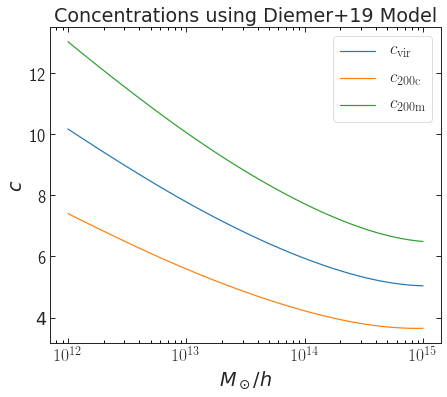

In [7]:
# mass-concentration relationships
# Original Shi paper used duffy08 and vdB+14 used the c(M,z) of Zhao+09
# need to make sure that we use consistent definitions of virial radius, thus concentration, everywhere
# takes the z=0 mass in units of Msun/h
nm = 50
masses = np.logspace(12,15,nm)
cvirs = concentration.concentration(masses, 'vir', 0.0, model = 'diemer19')
c200cs = concentration.concentration(masses, '200c', 0.0, model = 'diemer19')
c200ms = concentration.concentration(masses, '200m', 0.0, model = 'diemer19')
plot(semilogx=True)
plt.plot(masses, cvirs, label=r'$c_\mathrm{vir}$')
plt.plot(masses, c200cs, label=r'$c_\mathrm{200c}$')
plt.plot(masses, c200ms, label=r'$c_\mathrm{200m}$')
plt.title(r'Concentrations using Diemer+19 Model')
plt.legend()
plt.xlabel(r'$M_\odot / h$')
plt.ylabel(r'$c$')

# TODO: vdB+14 uses Zhao et al. 2009, not available in Colossus, so may need to code that up
# this uses the lookback time instead of redshift, so need to get z from t
# NOTE: vdB+14 paper and code use slightly different formulas
# We probably want to use one of the all-cosmology c(M,z) since we will use different definitions of the virial radius

In [8]:
# computing t_d from t_dyn
# the masses are in Msun/h
# the lengths for haloes are in kpc/h
def NFWf(x):
    return np.log(1. + x) - x/(1. + x)

# accepts radius in physical kpc/h
# might change this...
def NFWM(r, M, z, c, R):
    return M * NFWf(c*r/R) / NFWf(c)

def t_d(r, M, z, c, R, beta=beta_def):
    Menc = NFWM(r, M, z, c, R)
    t_dyn = 2. * np.pi * (r**3 / (G*Menc))**(1./2.) * km_per_kpc / (cosmology.getCurrent().H0 / 100.)
    return beta * t_dyn / s_per_Gyr / 2.

6.242115649063551


Text(0, 0.5, '$t_\\mathrm{d}$ [Gyr]')

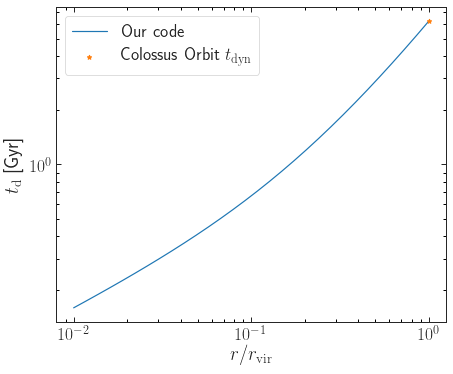

In [9]:
# look at t_d vs. r for a 10^14 Msun/h halo to verify the results

mass = 1e14 #Msun/h
Rvir = mass_so.M_to_R(mass, 0.0, 'vir')
nr = 30
rads = np.logspace(np.log10(0.01*Rvir),np.log10(Rvir), nr)

dt = mass_so.dynamicalTime(0.0, 'vir', definition='orbit')
print(dt / 2)

loglogplot()
plt.plot(rads/Rvir, t_d(rads, mass, 0.0, c=6, R=Rvir), label=r'Our code')
plt.plot([1.], [dt/2], '*', label=r'Colossus Orbit $t_\mathrm{dyn}$')
plt.legend()
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$t_\mathrm{d}$ [Gyr]')
# it agrees, so our calculation seems to be correct
# it disagrees by ~factor of 2~ with Shi and Komatsu, which is explained in their erratum
# hence, our result is indeed correct
# need to check later results to see if they actually use beta*t_dyn / 2 or beta*t_dyn for further stuff

In [10]:
# Komatsu and Seljak Model
# Here, c_nfw is defined using the virialization condition of Lacey & Cole (1993) and Nakamura & Suto (1997)
# should make sure that it is pretty similar to Bryan and Norman

def Gamma(c_nfw):
    return 1.15 + 0.01*(c_nfw - 6.5)

def eta0(c_nfw):
    return 0.00676*(c_nfw - 6.5)**2 + 0.206*(c_nfw - 6.5) + 2.48

def NFWPhi(r, M, z, conc_model='diemer19', mass_def='vir'):
    c = concentration.concentration(M, mass_def, z, model=conc_model)
    R = mass_so.M_to_R(M, z, mass_def)
    if(type(r) != np.ndarray and r == 0):
        return -1. * (G * M / R) * (c / NFWf(c))
    else:
        return -1. * (G * M / R) * (c / NFWf(c)) * (np.log(1. + c*r/R) / (c*r/R))

# this now agrees with Komatsu and Seljak eqn 19 for theta
# the confusion was that rho0 / P0 is 3*eta0^-1 and then units removed by scaling by R/GM
def theta(r, M, z, conc_model='diemer19', mass_def='vir'):
    c = concentration.concentration(M, mass_def, z, model=conc_model)
    R = mass_so.M_to_R(M, z, mass_def)
    # the rho0/P0 is actually 3eta^-1(0) * R/(GM) from Komatsu and Seljak
    rho0_by_P0 = 3*eta0(c)**-1 * R/(G*M)
    return 1. + ((Gamma(c) - 1.) / Gamma(c))*rho0_by_P0*(NFWPhi(0, M, z, conc_model='diemer19', mass_def='vir')-NFWPhi(r, M, z, conc_model='diemer19', mass_def='vir'))

# arbitrary units for now while we figure out what to do with the normalization
# likely won't need this
def rho_gas(r, M, z, conc_model='diemer19', mass_def='vir'):
    c = concentration.concentration(M, mass_def, z, model=conc_model)
    return theta(r, M, z, conc_model, mass_def)**(1.0 / (Gamma(c) - 1.0))

# in km/s
def sig2_tot_obsolete(r, M, z, conc_model='diemer19', mass_def='vir'):
    c = concentration.concentration(M, mass_def, z, model=conc_model)
    R = mass_so.M_to_R(M, z, mass_def)
    rho0_by_P0 = 3*eta0(c)**-1 * R/(G*M)
    return (1.0 / rho0_by_P0) * theta(r, M, z, conc_model, mass_def)

# the complete sig2_tot that only makes one of each relevant function call:
def sig2_tot(r, M, z, conc_model='diemer19', mass_def='vir'):
    c = concentration.concentration(M, mass_def, z, model=conc_model) # tabulated probably
    R = mass_so.M_to_R(M, z, mass_def) # tabulated probably
    rho0_by_P0 = 3*eta0(c)**-1 * R/(G*M)
    phi0 = -1. * (c / NFWf(c))
    phir = -1. * (c / NFWf(c)) * (np.log(1. + c*r/R) / (c*r/R))
    theta = 1. + ((Gamma(c) - 1.) / Gamma(c)) * 3. *eta0(c)**-1 * (phi0 - phir)
    return (1.0 / rho0_by_P0) * theta

# concentration increases with time
# radius also increases with time (hence why c increases)

Text(0, 0.5, '$\\frac{\\Gamma}{\\Gamma - 1}$')

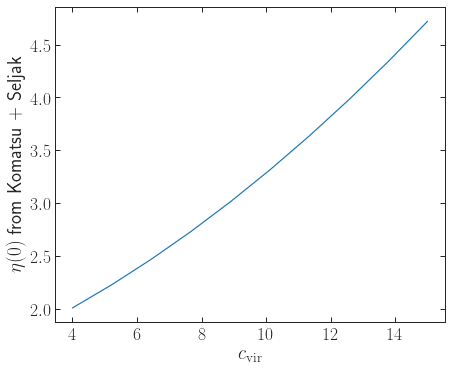

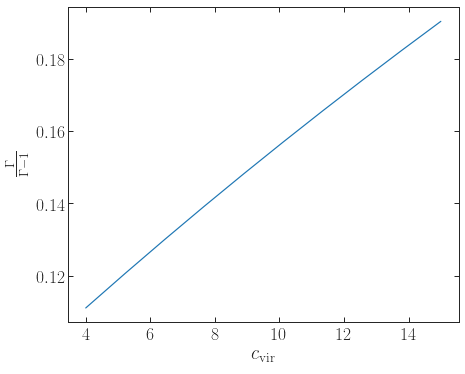

In [11]:
concs = np.linspace(4,15,10)
plot()
plt.plot(concs, eta0(concs))
plt.xlabel(r'$c_\mathrm{vir}$'); plt.ylabel(r'$\eta(0)$ from Komatsu + Seljak')
plot()
plt.plot(concs, ((Gamma(concs) - 1.) / Gamma(concs)))
plt.xlabel(r'$c_\mathrm{vir}$'); plt.ylabel(r'$\frac{\Gamma}{\Gamma - 1}$')

Text(0, 0.5, '$\\sigma_\\mathrm{tot}$ [km/s]')

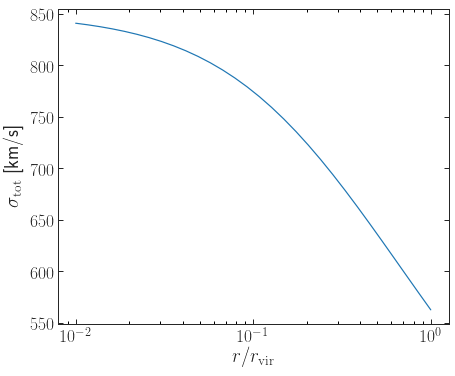

In [12]:
mass = 10**14.5 #Msun/h
Rvir = mass_so.M_to_R(mass, 0.0, 'vir')
nr = 30
rads = np.logspace(np.log10(0.01*Rvir),np.log10(Rvir), nr)

plot(semilogx=True)
plt.plot(rads/Rvir, (sig2_tot(rads, mass, 0.0, mass_def='vir'))**(1./2.))
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$\sigma_\mathrm{tot}$ [km/s]')

# what happens to Komatsu-Seljak model when you have c < 6.5?

# we now have recovered the result of Fig 4 from Komatsu and Seljak

In [13]:
zhao_exec_name = 'mandc.x'
vdb_exec_name = 'getPWGH'

# TODO: Update the calls to use names that change with the cosmology
# then we can check for the presence of a file for a given combo of m, z, and cosmo
# and if it is there already, we don't need to regenerate it
# this will speed up the reproduction of plots

# can convert to 200c, 200m if needed
def zhao_mah(Mobs, z_obs, cosmo):
    lgMobs = np.log10(Mobs)
    zpt = '%05d' % (np.round(z_obs, decimals=1)*100)
    mpt = '%05d' % (np.round(lgMobs, decimals=1)*100)
    df_name = 'mchistory_%s.%s.%s' % (cosmo_dict[cosmo.name], zpt, mpt)
    if(isfile(df_name)): # we've already generated this run
        data = np.loadtxt(df_name,skiprows=1)
    else:
        instring = '%s\n%.3f %.3f\n1\n%.3f\n%.3f\n%.3f\n%.4f %1.3f\n1\n%1.1f\n%2.1f' % (cosmo_dict[cosmo.name], cosmo.Om0, cosmo.Ode0, cosmo.H0/100., cosmo.sigma8, cosmo.ns, cosmo.Ob0, cosmo.Tcmb0, z_obs, lgMobs)
        command = "echo '%s' | %s/%s" % (instring, getcwd(), zhao_exec_name)
        process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
        process.wait()
        data = np.loadtxt(df_name,skiprows=1)
    # will update the line below if we want to use 200c/200m
    zeds = data[:,0]; mass = data[:,1]; conc = data[:,2]
    times = data[:,-1] / yr_per_Gyr / (cosmo.H0/100.);
    # wonder how sensitive the results are to the derivative method used
    dMdt = (mass[1:] - mass[:-1]) / (times[1:] - times[:-1])
    # setting the dMdt at present day to zero since we don't need to evolve past z=0
    dMdt = np.insert(dMdt, len(dMdt), 0)
    out = np.column_stack((zeds, mass, conc, dMdt))
    out = np.flip(out, axis=0)
    return(out)

# same units for both, dM/dt in Msun/h / Gyr, mass in Msun/h

def vdb_mah(Mobs, z_obs, cosmo, tp='average'):
    if(tp=='median'):
        med_or_avg = 0
    elif(tp=='average'):
        med_or_avg = 1
    df_out_name = 'PWGH_%s.dat' % tp # name used by Frank's code
    lgMobs = np.log10(Mobs)
    zpt = '%05d' % (np.round(z_obs, decimals=1)*100)
    mpt = '%05d' % (np.round(lgMobs, decimals=1)*100)
    df_name = 'PWGH_%s.%s.%s' % (cosmo_dict[cosmo.name], zpt, mpt) # name we will save file as
    if(isfile(df_name)): # we've already generated this run
        data = np.loadtxt(df_name)
    else:
        instring = '%.3f\n%.3f\n%.3f\n%.3f\n%.4f\n%1.1E\n%1.1f\n%1d' % (cosmo.Om0, cosmo.H0/100., cosmo.sigma8, cosmo.ns, cosmo.Ob0*(cosmo.H0/100.)**2, Mobs, z_obs, med_or_avg)
        command = "echo '%s' | %s/%s; mv %s %s" % (instring, getcwd(), vdb_exec_name, df_out_name, df_name)
        process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
        process.wait()
        data = np.loadtxt(df_name)
    zeds = data[:,1]; mass = 10**data[:,3] * Mobs
    conc = data[:,6]; dMdt = data[:,7] * yr_per_Gyr
    out = np.column_stack((zeds, mass, conc, dMdt))
    out = np.flip(out, axis=0)
    return(out)

# will want to do the same thing here with the Parkinson model, but give it a third dimension which corresponds to
# the number of trees


Text(0, 0.5, '$M$')

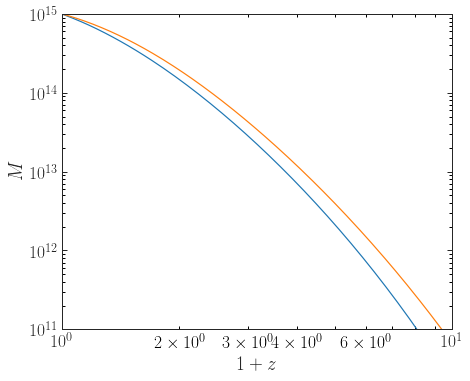

In [14]:
cosmo = cosmology.setCosmology('WMAP5')
zd = zhao_mah(10**15, 0.0, cosmo)
vd = vdb_mah(10**15, 0.0, cosmo)

loglogplot()
plt.plot(1+zd[:,0],zd[:,1], label='Zhao+09')
plt.plot(1+vd[:,0],vd[:,1], label='vdB+14')
plt.xlim(1,10)
plt.ylim(10**11,10**15)
plt.xlabel(r'$1+z$')
plt.ylabel(r'$M$')

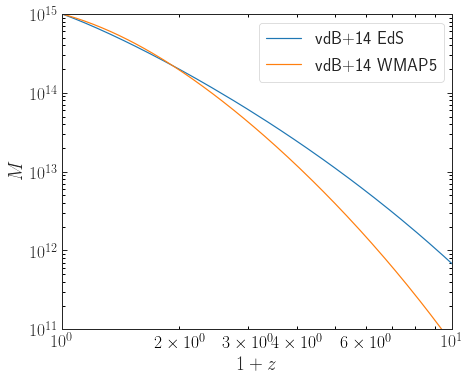

In [15]:
loglogplot()
cosmo = cosmology.setCosmology('near_EdS')
vd = vdb_mah(10**15, 0.0, cosmo)
plt.plot(1+vd[:,0],vd[:,1], label='vdB+14 EdS')
cosmo = cosmology.setCosmology('WMAP5')
vd = vdb_mah(10**15, 0.0, cosmo)
plt.plot(1+vd[:,0],vd[:,1], label='vdB+14 WMAP5')

plt.xlim(1,10)
plt.ylim(10**11,10**15)
plt.xlabel(r'$1+z$')
plt.ylabel(r'$M$')
plt.legend()
# Frank's code does not work for EdS

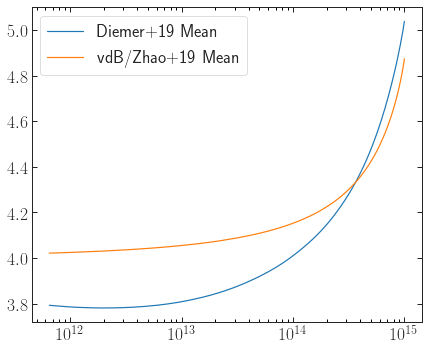

In [16]:
vdb_dat = vdb_mah(10**15, 0.0, cosmo)

masses = vdb_dat[:,1]
zeds = vdb_dat[:,0]
msk = zeds <= 6
vdb_concs = vdb_dat[:,2]
concs = np.zeros(len(vdb_dat))
for i in range(0,len(concs)):
    concs[i] = concentration.concentration(masses[i], 'vir', zeds[i], model = 'diemer19')

plot(semilogx=True)
plt.plot(masses[msk], concs[msk], label='Diemer+19 Mean')
plt.plot(masses[msk], vdb_concs[msk], label='vdB/Zhao+19 Mean')
plt.legend()

0.008233118259693672 0.3467672404220167


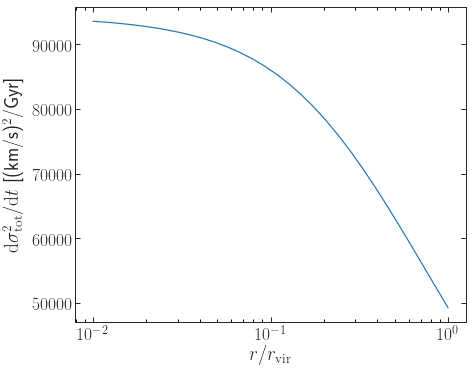

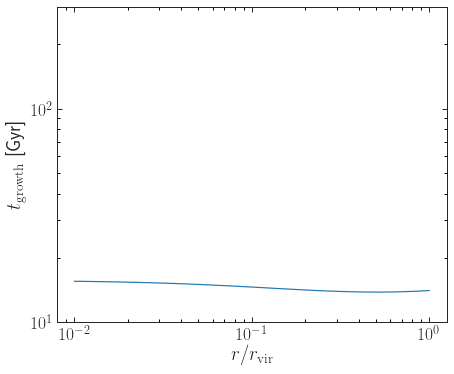

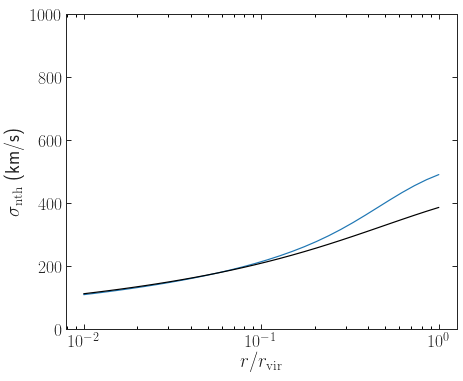

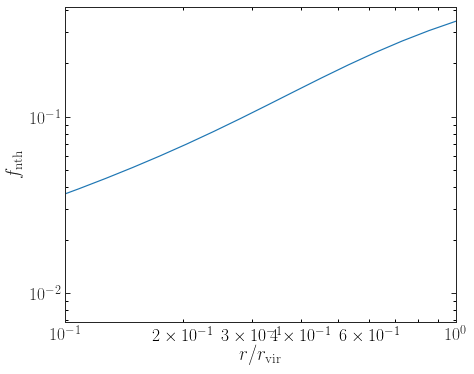

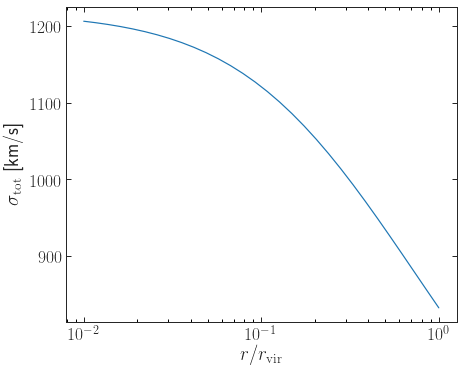

In [17]:
warnings.simplefilter('ignore')
cosmo = cosmology.setCosmology('WMAP5')
# pipeline takes in Mobs, z, cosmology
# computes the dsigma^2/dt for each radius

Mobs = 10**15
zobs = 0.0
mass_def = 'vir'
conc_model='duffy08' # will definitely want to try changing this
nrads = 30

# need to make sure that when we change the cosmology, all things are properly updated

zhao_dat = zhao_mah(Mobs, zobs, cosmo)
first_snap_to_use = np.where(zhao_dat[:,0] <= 6.)[0][0] - 1
zhao_dat = zhao_dat[first_snap_to_use:]

def sig2_tot(r, M, c, R):
    rho0_by_P0 = 3*eta0(c)**-1 * R/(G*M)
    phi0 = -1. * (c / NFWf(c))
    phir = -1. * (c / NFWf(c)) * (np.log(1. + c*r/R) / (c*r/R))
    theta = 1. + ((Gamma(c) - 1.) / Gamma(c)) * 3. *eta0(c)**-1 * (phi0 - phir)
    return (1.0 / rho0_by_P0) * theta

n_steps = zhao_dat.shape[0] - 1

Robs = mass_so.M_to_R(Mobs, zobs, mass_def)

rads = np.logspace(np.log10(0.01*Robs),np.log10(Robs), nrads)

ds2dt = np.zeros((n_steps, nrads))
sig2tots = np.zeros((n_steps, nrads))
sig2nth = np.zeros((n_steps, nrads))

for i in range(0, n_steps):
    z_1 = zhao_dat[i,0] #first redshift
    z_2 = zhao_dat[i+1,0] #second redshift, the one we are actually at
    dt = cosmo.age(z_2) - cosmo.age(z_1) # in Gyr
    mass_1 = zhao_dat[i,1]
    mass_2 = zhao_dat[i+1,1]
    dM = mass_2 - mass_1
    dMdt = zhao_dat[i+1,3] # since the (i+1)th is computed between i+1 and i
    R_1 = mass_so.M_to_R(mass_1, z_1, mass_def)
    R_2 = mass_so.M_to_R(mass_2, z_2, mass_def)
    c_1 = concentration.concentration(mass_1, mass_def, z_1, model = 'duffy08') #zhao_dat[i,2]
    c_2 = concentration.concentration(mass_2, mass_def, z_2, model = 'duffy08') #zhao_dat[i+1,2]
    sig2tots[i,:] = sig2_tot(rads, mass_2, c_2, R_2) # second snapshot
    if(i==0):
        # update this to accept general eta
        ds2dt[i,:] = (sig2tots[i,:] - sig2_tot(rads, mass_1, c_1, R_1)) / dt # see if this works better, full change
        sig2nth[i,:] = eta_def * sig2tots[i,:] # starts at z_i = 6 roughly
    else:
        ds2dt[i,:] = (sig2tots[i,:] - sig2tots[i-1,:]) / dt
        td = t_d(rads, mass_2, z_2, c_2, R_2, beta=beta_def) #t_d at z of interest z_2
        sig2nth[i,:] = sig2nth[i-1] + ((-1. * sig2nth[i-1,:] / td) + eta_def * ds2dt[i,:])*dt
        # here we can see if it is td or 2td that we are using in comparison

# seems that we are able to reproduce the Shi+ results only when we use the Duffy+08 concentration
# which has its own issues, but we'll mitigate this by using merger trees in future and independent concentrations

plot(semilogx=True)
plt.plot(rads/Robs, ds2dt[-1,:])
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$\mathrm{d}\sigma_\mathrm{tot}^2 /\mathrm{d}t$ [(km/s)$^2$/Gyr]')

tgrowth = sig2tots / np.abs(ds2dt)
loglogplot() 
plt.plot(rads/Robs, tgrowth[-1,:])
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$t_\mathrm{growth}$ [Gyr]')
plt.ylim(10**1, 3*10**2)

td = t_d(rads, zhao_dat[-1,1], zhao_dat[-1,0], zhao_dat[-1,2], mass_so.M_to_R(zhao_dat[-1,1], zhao_dat[-1,0], 'vir'), beta=beta_def)
fnth_lim = eta_def * td / (td + tgrowth[-1,:])

plot(semilogx=True)
plt.plot(rads/Robs, np.sqrt(sig2nth[-1,:]))
plt.plot(rads/Robs, np.sqrt(fnth_lim) * np.sqrt(sig2tots[-1,:]), color='k')
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$\sigma_\mathrm{nth}$ (km/s)')
plt.ylim(0,1000)

loglogplot()
fnth = sig2nth[-1,:] / sig2tots[-1,:]
print(np.min(fnth),np.max(fnth)) # currently not changing much... still a bug
plt.plot(rads/Robs, fnth)
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$f_\mathrm{nth}$')
plt.xlim(10**-1, 1.)

plot(semilogx=True)
plt.plot(rads/Robs, np.sqrt(sig2tots[-1,:])) # this is correct still
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$\sigma_\mathrm{tot}$ [km/s]')

# once we can *roughly* reproduce the results of Shi+14, we're ready to start trying different masses, redshifts, cosmos
warnings.simplefilter('default')

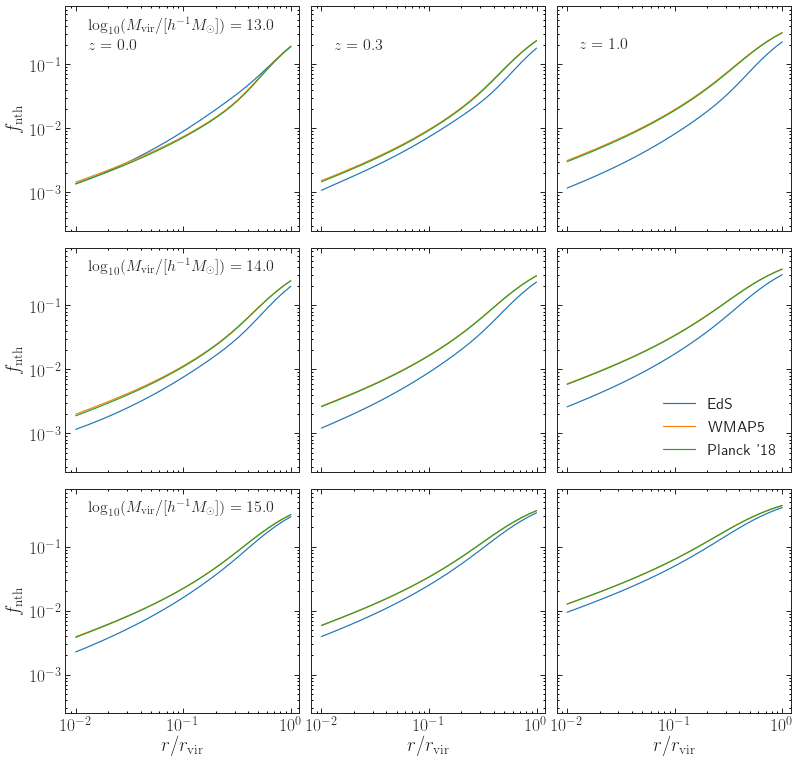

In [103]:
warnings.simplefilter('ignore')
# let's make a function out of the stuff below and then loop over several masses and redshifts
# then we can add in cosmologies

def sig2_tot(r, M, c, R):
    rho0_by_P0 = 3*eta0(c)**-1 * R/(G*M)
    phi0 = -1. * (c / NFWf(c))
    phir = -1. * (c / NFWf(c)) * (np.log(1. + c*r/R) / (c*r/R))
    theta = 1. + ((Gamma(c) - 1.) / Gamma(c)) * 3. *eta0(c)**-1 * (phi0 - phir)
    return (1.0 / rho0_by_P0) * theta

#takes in Mobs, zobs, cosmo
#returns f_nth, sig2nth, sig2tot at z=zobs
def gen_fnth(Mobs, zobs, cosmo, mah_retriever=zhao_mah, mass_def='vir', conc_model='duffy08', beta=beta_def, eta=eta_def, nrads=30, zi=6.):
    data = mah_retriever(Mobs, zobs, cosmo)
    first_snap_to_use = np.where(data[:,0] <= zi)[0][0] - 1
    data = data[first_snap_to_use:]

    n_steps = data.shape[0] - 1

    Robs = mass_so.M_to_R(Mobs, zobs, mass_def)

    rads = np.logspace(np.log10(0.01*Robs),np.log10(Robs), nrads)

    ds2dt = np.zeros((n_steps, nrads))
    sig2tots = np.zeros((n_steps, nrads))
    sig2nth = np.zeros((n_steps, nrads))

    # this process can probably be made more pythonic so that the looping is faster
    # will be very important for once we work with a merger tree instead
    # computing the concentrations is definitely the bottleneck
    # if using ludlow/zhao, do it array-wise so we get them all for one computation instead of repeated
    for i in range(0, n_steps):
        z_1 = data[i,0] #first redshift
        z_2 = data[i+1,0] #second redshift, the one we are actually at
        dt = cosmo.age(z_2) - cosmo.age(z_1) # in Gyr
        mass_1 = data[i,1]
        mass_2 = data[i+1,1]
        dM = mass_2 - mass_1
        dMdt = data[i+1,3] # since the (i+1)th is computed between i+1 and i
        R_1 = mass_so.M_to_R(mass_1, z_1, mass_def)
        R_2 = mass_so.M_to_R(mass_2, z_2, mass_def)
        if(conc_model == 'vdb'):
            c_1 = data[i,2]
            c_2 = data[i+1,2]
        else:
            c_1 = concentration.concentration(mass_1, mass_def, z_1, model=conc_model)
            c_2 = concentration.concentration(mass_2, mass_def, z_2, model=conc_model)
        sig2tots[i,:] = sig2_tot(rads, mass_2, c_2, R_2) # second snapshot
        if(i==0):
            # update this to accept general eta
            ds2dt[i,:] = (sig2tots[i,:] - sig2_tot(rads, mass_1, c_1, R_1)) / dt # see if this works better, full change
            sig2nth[i,:] = eta_def * sig2tots[i,:] # starts at z_i = 6 roughly
        else:
            ds2dt[i,:] = (sig2tots[i,:] - sig2tots[i-1,:]) / dt
            td = t_d(rads, mass_2, z_2, c_2, R_2, beta=beta_def) #t_d at z of interest z_2
            sig2nth[i,:] = sig2nth[i-1] + ((-1. * sig2nth[i-1,:] / td) + eta_def * ds2dt[i,:])*dt
    fnth = sig2nth[-1,:] / sig2tots[-1,:]
    return fnth, rads, sig2nth[-1,:], sig2tots[-1,:]


masses = [10**13, 10**14, 10**15]
zeds = [0.0, 0.3, 1.0]
cosmologies = ['near_EdS','WMAP5','planck18']
fancy_cosms = ['EdS', 'WMAP5', "Planck '18"]

def plot_3cosmos(masses, zeds, cosmologies, fancy_cosms, mah_retriever=vdb_mah, mass_def='vir', conc_model='vdb', beta=beta_def, eta=eta_def):
    fig, ax = plt.subplots(nrows=len(masses),ncols=len(zeds),figsize=(13,13), sharex=True, sharey=True, gridspec_kw={'wspace':0.05,'hspace':0.075})
    for i in range(0,3):
        for j in range(0,3):
            ax[i,j].yaxis.set_ticks_position('both')
            ax[i,j].xaxis.set_ticks_position('both')
            ax[i,j].tick_params(axis='both', which='minor', colors='black', width=1.0, length=2.0)
            ax[i,j].loglog()
            ax[i,j].set_ylim(2.5e-4,0.8)
            ax[i,j].set_xlim(0.8*1e-2,1*1.2)
            #ax[i,j].xaxis.set_minor_locator(MultipleLocator(0.2))
            #ax[i,j].yaxis.set_minor_locator(MultipleLocator(0.05))


    # can generate colors based on the cosmology

    for i,m in enumerate(masses):
        for j,z in enumerate(zeds):
            for k,cosm in enumerate(cosmologies):
                #print(i,j,k)
                cosmo = cosmology.setCosmology(cosm)
                fnth, rads, _, _ = gen_fnth(m, z, cosmo, mah_retriever, mass_def, conc_model, beta, eta)
                ax[i,j].plot(rads/rads[-1], fnth, label=fancy_cosms[k])


    for i in range(0,len(masses)):
        ax[i,0].set_ylabel(r'$f_\mathrm{nth}$')
        ax[i,0].text(1.3e-2,3e-1,r'$\log_{10}(M_\mathrm{vir}/[h^{-1}M_\odot])=%.1f$' % np.log10(masses[i]), fontsize=16)
    for i in range(0,len(zeds)):
        ax[len(masses)-1,i].set_xlabel(r'$r/r_\mathrm{vir}$')
        ax[0,i].text(1.3e-2,1.7e-1,r'$z=%.1f$' % zeds[i], fontsize=16)

    ax[1,len(zeds)-1].legend(frameon=False,fontsize=16)
    return fig, ax

# clearly, the different cosmologies look different, but this is sensitive to concentration definition
# we can see how different things are using different concentration definitions and using vdB vs. Zhao
# also want to see how things look *outside Rvir* perhaps out to r200m

plot_3cosmos(masses, zeds, cosmologies, fancy_cosms, conc_model='vdb', mah_retriever=vdb_mah)

warnings.simplefilter('default')

# probably not going to be able to tell the difference between WMAP5 and Planck 18 with this method...

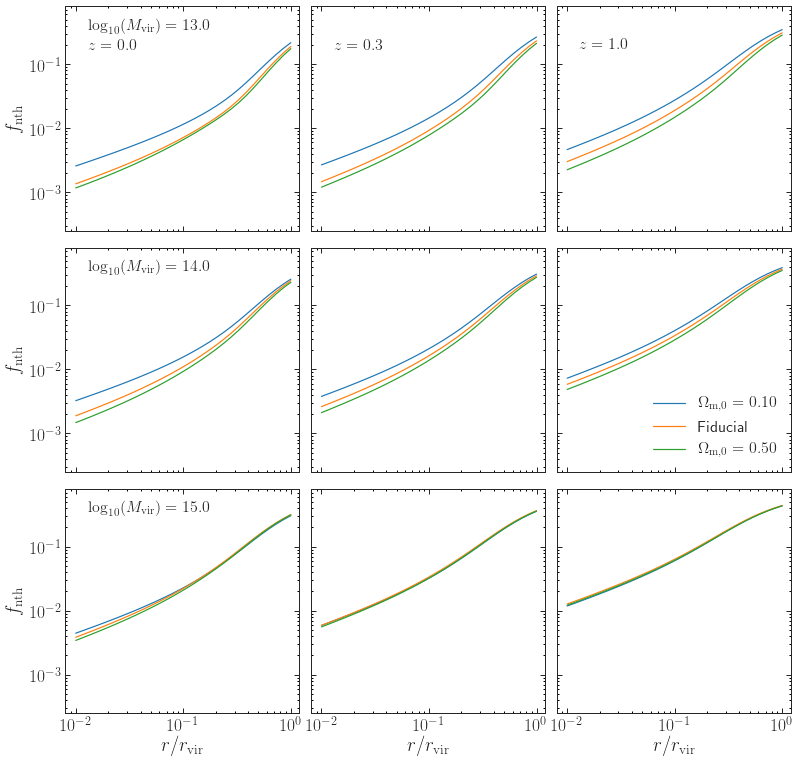

In [37]:
masses = [10**13, 10**14, 10**15]
zeds = [0.0, 0.3, 1.0]
cosmologies = ['pl18_lowOm0','planck18','pl18_hiOm0']
fancy_cosms = [r'$\Omega_\mathrm{m,0}=%.2f$' % cosmology.cosmologies[cosmologies[0]]['Om0'], r'Fiducial', r'$\Omega_\mathrm{m,0}=%.2f$' % cosmology.cosmologies[cosmologies[-1]]['Om0']]
plot_3cosmos(masses, zeds, cosmologies, fancy_cosms, conc_model='vdb', mah_retriever=vdb_mah);

# changing Omega_matter has a reasonable effect

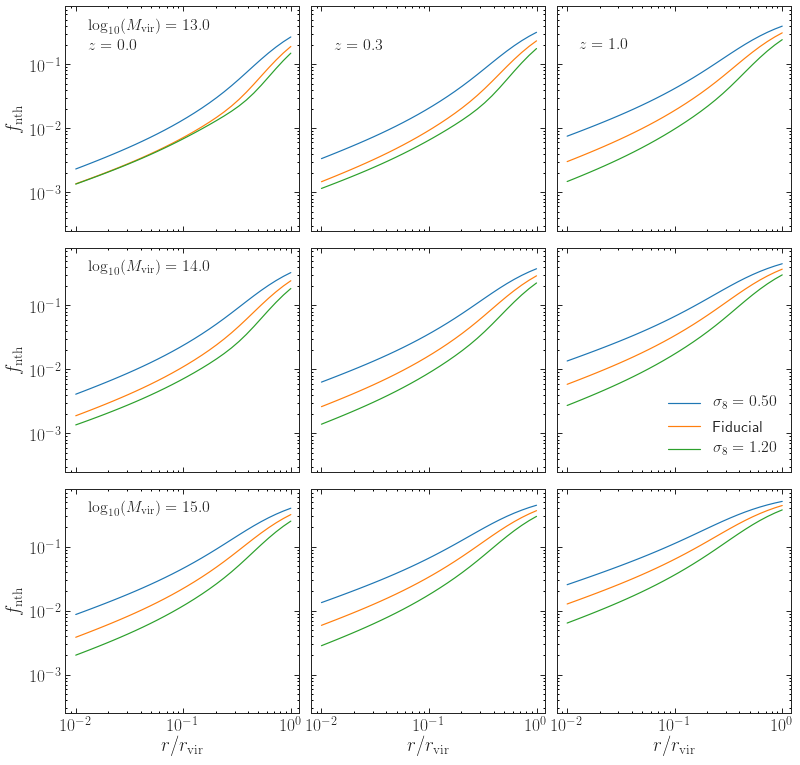

In [38]:
cosmologies = ['pl18_lows8','planck18','pl18_his8']
fancy_cosms = [r'$\sigma_8=%.2f$' % cosmology.cosmologies[cosmologies[0]]['sigma8'], r'Fiducial', r'$\sigma_8=%.2f$' % cosmology.cosmologies[cosmologies[-1]]['sigma8']]
plot_3cosmos(masses, zeds, cosmologies, fancy_cosms, conc_model='vdb', mah_retriever=vdb_mah);

# changing sigma_8 has a very large effect

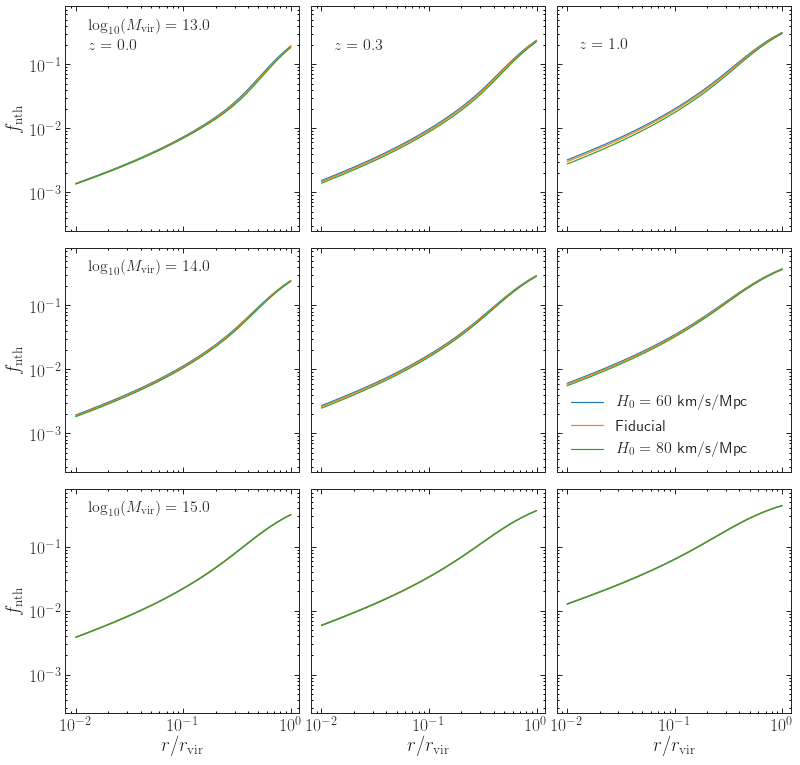

In [39]:
cosmologies = ['pl18_lowH0','planck18','pl18_hiH0']
fancy_cosms = [r'$H_0=%.0f$ km/s/Mpc' % cosmology.cosmologies[cosmologies[0]]['H0'], r'Fiducial', r'$H_0=%.0f$ km/s/Mpc' % cosmology.cosmologies[cosmologies[-1]]['H0']]
plot_3cosmos(masses, zeds, cosmologies, fancy_cosms, conc_model='vdb', mah_retriever=vdb_mah);

# H_0 has basically no effect

In [19]:
for cosm in ['pl18_s8_1_1','pl18_s8_1_2', 'planck18', 'pl18_s8_p6_1', 'pl18_s8_p6_2']:
    cosmology.setCosmology(cosm)
    print(cosmology.getCurrent())

Cosmology "pl18_s8_1_1" 
    flat = True, Om0 = 0.3000, Ode0 = 0.6999, Ob0 = 0.0490, H0 = 67.66, sigma8 = 1.0000, ns = 0.9665
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False
Cosmology "pl18_s8_1_2" 
    flat = True, Om0 = 0.4690, Ode0 = 0.5309, Ob0 = 0.0490, H0 = 67.66, sigma8 = 0.8000, ns = 0.9665
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False
Cosmology "planck18" 
    flat = True, Om0 = 0.3111, Ode0 = 0.6888, Ob0 = 0.0490, H0 = 67.66, sigma8 = 0.8102, ns = 0.9665
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False
Cosmology "pl18_s8_p6_1" 
    flat = True, Om0 = 0.3000, Ode0 = 0.6999, Ob0 = 0.0490, H0 = 67.66, sigma8 = 0.6000, ns = 0.9665
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False
Cosmology "pl18_s8_p6_2" 
    flat = True, Om0 = 0.4320, Ode0 = 0.5679, Ob0 = 0.0490, H0 = 67.66, sigma8 = 0.5000, ns = 0.9665
    de_mode

/home/sbg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ResourceWarning: unclosed file <_io.BufferedReader name=59>
  from ipykernel import kernelapp as app


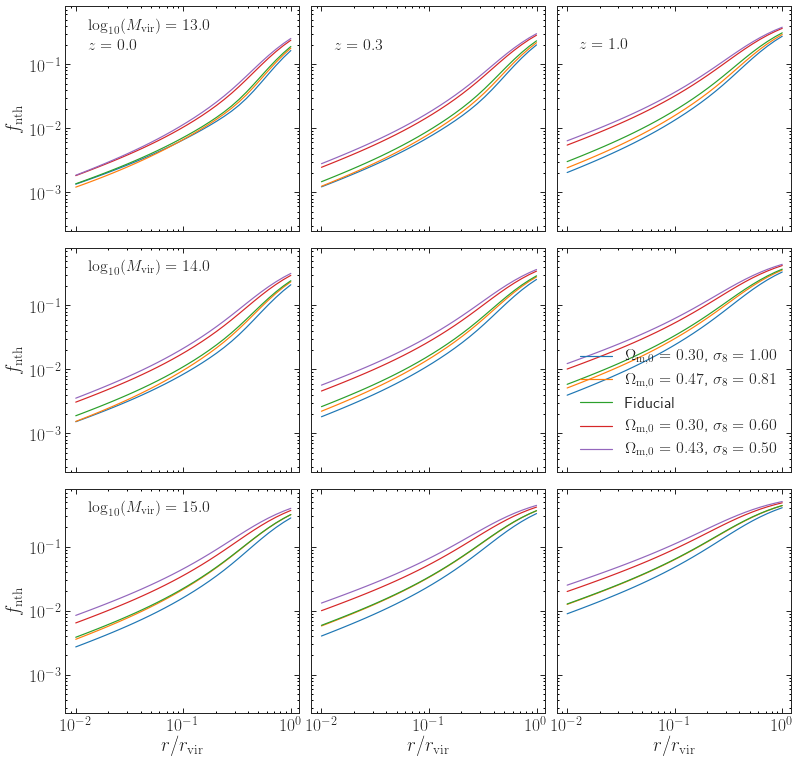

In [22]:
# testing varying s8, first with the high S_8
# then with the low S_8
# and then if they look the same as long as S_8 fixed, then we can compare different values of S_8


masses = [10**13, 10**14, 10**15]
zeds = [0.0, 0.3, 1.0]
cosmologies = ['pl18_s8_1_1','pl18_s8_1_2', 'planck18', 'pl18_s8_p6_1', 'pl18_s8_p6_2']
fancy_cosms = [r'$\Omega_\mathrm{m,0}=%.2f$, $\sigma_8=%.2f$' % (cosmology.cosmologies[cosmologies[0]]['Om0'], cosmology.cosmologies[cosmologies[0]]['sigma8']), 
               r'$\Omega_\mathrm{m,0}=%.2f$, $\sigma_8=%.2f$' % (cosmology.cosmologies[cosmologies[1]]['Om0'], cosmology.cosmologies[cosmologies[2]]['sigma8']),
               r'Fiducial',
               r'$\Omega_\mathrm{m,0}=%.2f$, $\sigma_8=%.2f$' % (cosmology.cosmologies[cosmologies[3]]['Om0'], cosmology.cosmologies[cosmologies[3]]['sigma8']), 
               r'$\Omega_\mathrm{m,0}=%.2f$, $\sigma_8=%.2f$' % (cosmology.cosmologies[cosmologies[4]]['Om0'], cosmology.cosmologies[cosmologies[4]]['sigma8'])]
fig, ax = plot_3cosmos(masses, zeds, cosmologies, fancy_cosms, conc_model='vdb', mah_retriever=vdb_mah);

In [139]:
def multimah(Mobs, z_obs, cosmo, Nmah, tp='average'):
    # loads in an array of MAH from Frank's MAH code, specify Nmah = number of MAH to get
    mass_int = int(np.log10(Mobs)*10)
    z_int = int(z_obs*100)
    mah_dir = multimah_root / ('%s/m%03d/z%03d' % (cosmo.name, mass_int, z_int))
    dat1 = np.loadtxt(mah_dir / 'MAH0001.dat')
    redshifts = dat1[:,1]
    lbtime = dat1[:,2]
    nz = len(dat1)
    dat = np.zeros((Nmah, nz))
    std = np.zeros((nz,2))
    for i in range(0,Nmah):
        dat[i,:] = np.loadtxt(mah_dir / ('MAH%04d.dat' %(i+1)), usecols=3)
    dat = 10**dat
    if(tp == 'full'):
        # return the full array instead of giving standard deviations
        return dat*Mobs, redshifts, lbtime
    elif(tp == 'average'):
        mah = np.average(dat, axis=0)
        std[:,0] = np.std(dat, axis=0)
        std[:,1] = std[:,0]
    elif(tp == 'median'):
        mah = np.median(dat, axis=0)
        std[:,0] = mah - np.percentile(dat, 16, axis=0)
        std[:,1] = np.percentile(dat, 84, axis=0) - mah
    mah = mah * Mobs
    std = std * Mobs
    return mah, std, redshifts, lbtime

Text(0.5, 1.0, 'Individual MAHs')

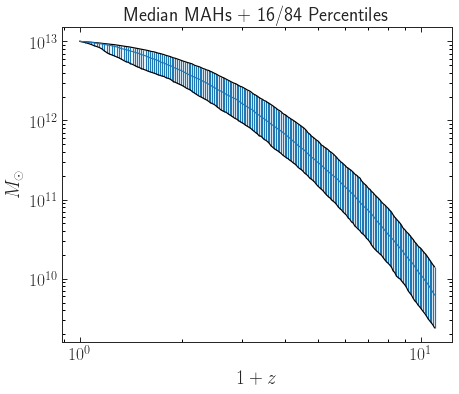

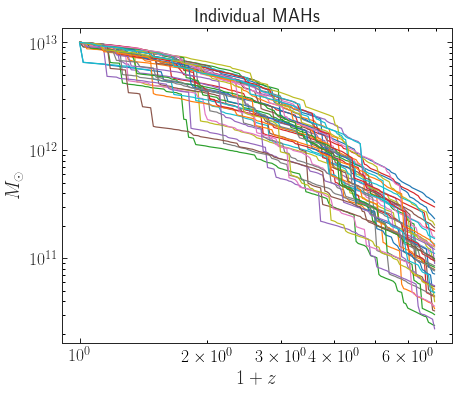

In [250]:
# let's look at some test cases: z=0, 10**13 Msun, individual and median/average MAHs

cosmo = cosmology.setCosmology('planck18')

mah, std, redshifts, lbtime = multimah(10**13, 0.0,cosmo,1000, tp='median')

loglogplot()
msk = redshifts < 10
plt.errorbar(1+redshifts[msk], mah[msk], std[msk].T)
plt.plot(1+redshifts[msk], mah[msk] - std[msk,0], color='k')
plt.plot(1+redshifts[msk], mah[msk] + std[msk,1], color='k')
#mah, std, redshifts, lbtime = multimah(10**13, 0.0,cosmo,1000, tp='average')
#plt.errorbar(1+redshifts[msk], mah[msk], std[msk].T)
plt.xlabel(r'$1+z$')
plt.ylabel(r'$M_\odot$')
plt.title(r'Median MAHs + 16/84 Percentiles')

mah, redshifts, lbtime = multimah(10**13, 0.0,cosmo,1000, tp='full')

loglogplot()
msk = redshifts < 6.
for i in range(0, 40):
    plt.plot(1+redshifts[msk], mah[i,msk])
plt.xlabel(r'$1+z$')
plt.ylabel(r'$M_\odot$')
plt.title(r'Individual MAHs')

0.409953237


(array([  1.,   1.,   0.,   1.,   3.,   3.,   2.,   7.,   6.,   6.,  10.,
         17.,  23.,  29.,  19.,  22.,  22.,  23.,  23.,  32.,  31.,  24.,
         36.,  30.,  43.,  55.,  63.,  52.,  71., 120., 153.,  72.]),
 array([1.45545944e+12, 1.68467102e+12, 1.91388261e+12, 2.14309419e+12,
        2.37230577e+12, 2.60151736e+12, 2.83072894e+12, 3.05994052e+12,
        3.28915211e+12, 3.51836369e+12, 3.74757527e+12, 3.97678686e+12,
        4.20599844e+12, 4.43521002e+12, 4.66442161e+12, 4.89363319e+12,
        5.12284477e+12, 5.35205636e+12, 5.58126794e+12, 5.81047952e+12,
        6.03969111e+12, 6.26890269e+12, 6.49811427e+12, 6.72732586e+12,
        6.95653744e+12, 7.18574902e+12, 7.41496061e+12, 7.64417219e+12,
        7.87338378e+12, 8.10259536e+12, 8.33180694e+12, 8.56101853e+12,
        8.79023011e+12]),
 <a list of 32 Patch objects>)

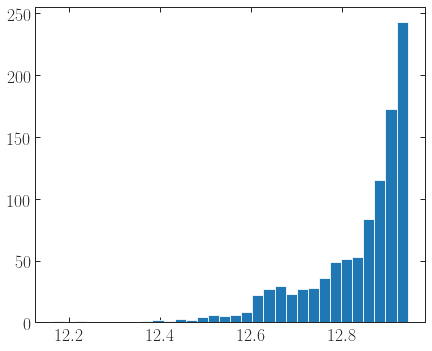

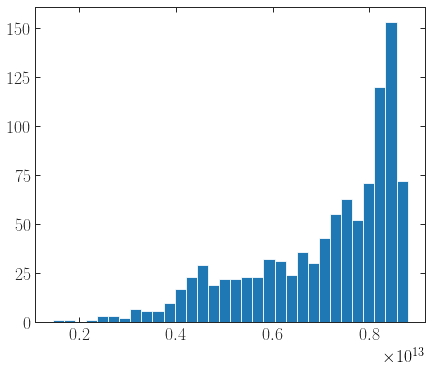

In [251]:
# demonstrating that the MAH masses at a given redshift are not normally distributed
mah, redshifts, lbtime = multimah(10**13, 0.0,cosmo,1000, tp='full')
plot()
numz = 20
print(redshifts[numz])
plt.hist(np.log10(mah[:,numz]), bins='sqrt')
plot()
plt.hist(mah[:,numz], bins='sqrt')

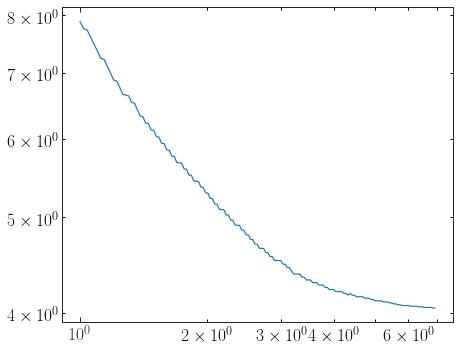

In [253]:
mah, std, redshifts, lbtime = multimah(10**13, 0.0,cosmo,1000, tp='median')

z0 = 0.0
t0 = cosmo.age(z0)

nz_msk = len(redshifts[msk])
concs = np.zeros(nz_msk)

for i in range(0,nz_msk):
    t = t0 - lbtime[i]
    m04 = 0.04 * mah[i]
    t04_ind = np.where(mah > m04)[0][-1]
    t04 = t0 - lbtime[t04_ind]
    concs[i] = zhao_vdb_conc(t, t04)

loglogplot()
plt.plot(1+redshifts[msk], concs)

# these concentrations are in agreement with Frank's Coming of Age paper

In [247]:
# modifying the gen_fnth function to do it using the individual MAHs from Frank's code
# as well as to compute fnth using the percentiles/median of the MAHs from Frank's code

def zhao_vdb_conc(t, t04):
    return 4.0 * (1.0 + (t / (3.40*t04))**6.5)**(1.0/8.0)

# IMPLEMENT LUDLOW 16 MODEL HERE

def gen_fnth_ind(Mobs, zobs, cosmo, mass_def='vir', conc_model=zhao_vdb_conc, Nmah=1000, beta=beta_def, eta=eta_def, nrads=30, zi=6.):
    #takes in Mobs, zobs, cosmo
    #returns f_nth, sig2nth, sig2tot at z=zobs

    mah, redshifts, lbtime = multimah(Mobs, zobs, cosmo, Nmah, tp='full')
    z6_snap = np.where(redshifts <= zi)[0][-1] + 1 #first snap over z=6
    #data = data[first_snap_to_use:]
    t0 = cosmo.age(0) # this way we can easily get proper times using the lookback times from Frank's files

    n_steps = z6_snap

    Robs = mass_so.M_to_R(Mobs, zobs, mass_def)

    rads = np.logspace(np.log10(0.01*Robs),np.log10(Robs), nrads)

    ds2dt = np.zeros((Nmah, n_steps, nrads))
    sig2tots = np.zeros((Nmah, n_steps, nrads))
    sig2nth = np.zeros((Nmah, n_steps, nrads))
    fnth    = np.zeros((Nmah,nrads))

    for mc in range(0,Nmah):
        if(mc % 10 == 0):
            print(mc)
        for i in range(z6_snap,0,-1):
            z_1 = redshifts[i] #first redshift
            z_2 = redshifts[i-1] #second redshift, the one we are actually at
            dt = lbtime[i] - lbtime[i-1] # in Gyr
            mass_1 = mah[mc, i] #dat = np.zeros((Nmah, nz))
            mass_2 = mah[mc, i-1]
            dM = mass_2 - mass_1
            dMdt = dM/dt # since the (i+1)th is computed between i+1 and i
            R_1 = mass_so.M_to_R(mass_1, z_1, mass_def)
            R_2 = mass_so.M_to_R(mass_2, z_2, mass_def)
            
            time_1 = t0 - lbtime[i]
            time_2 = t0 - lbtime[i-1]
            m04_1  = 0.04 * mass_1
            m04_2  = 0.04 * mass_2
            t04_ind_1 = np.where(mah[mc,:] > m04_1)[0][-1]
            t04_ind_2 = np.where(mah[mc,:] > m04_2)[0][-1]
            t04_1 = t0 - lbtime[t04_ind_1]
            t04_2 = t0 - lbtime[t04_ind_2]

            c_1 = conc_model(time_1, t04_1) 
            c_2 = conc_model(time_2, t04_2)
            sig2tots[mc,i-1,:] = sig2_tot(rads, mass_2, c_2, R_2) # second snapshot
            if(i==z6_snap):
                ds2dt[mc,i-1,:] = (sig2tots[mc,i-1,:] - sig2_tot(rads, mass_1, c_1, R_1)) / dt # see if this works better, full change
                sig2nth[mc,i-1,:] = eta_def * sig2tots[mc,i-1,:] # starts at z_i = 6 roughly
            else:
                ds2dt[mc,i-1,:] = (sig2tots[mc,i-1,:] - sig2tots[mc,i,:]) / dt
                td = t_d(rads, mass_2, z_2, c_2, R_2, beta=beta_def) #t_d at z of interest z_2
                sig2nth[mc,i-1,:] = sig2nth[mc,i,:] + ((-1. * sig2nth[mc,i,:] / td) + eta_def * ds2dt[mc,i-1,:])*dt
                sig2nth[mc,i-1, sig2nth[mc,i-1,:] < 0] = 0 #can't have negative sigma^2_nth
        fnth[mc,:] = sig2nth[mc,0,:] / sig2tots[mc,0,:]
    #fnth[fnth < 0] = 0
    return fnth, rads #, sig2nth[-1,:], sig2tots[-1,:] #PENDING 

def gen_fnth_avg_mean(Mobs, zobs, cosmo, mass_def='vir', conc_model=zhao_vdb_conc, tp='median', Nmah=1000, beta=beta_def, eta=eta_def, nrads=30, zi=6.):
    mah, std, redshifts, lbtime = multimah(Mobs, zobs, cosmo, Nmah, tp)
    z6_snap = np.where(redshifts <= zi)[0][-1] + 1 #first snap over z=6
    #data = data[first_snap_to_use:]
    t0 = cosmo.age(zobs)

    n_steps = z6_snap

    Robs = mass_so.M_to_R(Mobs, zobs, mass_def)

    rads = np.logspace(np.log10(0.01*Robs),np.log10(Robs), nrads)

    ds2dt = np.zeros((3, n_steps, nrads))
    sig2tots = np.zeros((3, n_steps, nrads))
    sig2nth = np.zeros((3, n_steps, nrads))
    fnth    = np.zeros((3,nrads))
    
    mah = np.array([mah - std[:,0], mah, mah + std[:,1]])

    for mc in range(0,3):
        for i in range(z6_snap,0,-1):
            z_1 = redshifts[i] #first redshift
            z_2 = redshifts[i-1] #second redshift, the one we are actually at
            dt = lbtime[i] - lbtime[i-1] # in Gyr
            mass_1 = mah[mc, i] #dat = np.zeros((Nmah, nz))
            mass_2 = mah[mc, i-1]
            dM = mass_2 - mass_1
            dMdt = dM/dt # since the (i+1)th is computed between i+1 and i
            R_1 = mass_so.M_to_R(mass_1, z_1, mass_def)
            R_2 = mass_so.M_to_R(mass_2, z_2, mass_def)
            
            time_1 = t0 - lbtime[i]
            time_2 = t0 - lbtime[i-1]
            m04_1  = 0.04 * mass_1
            m04_2  = 0.04 * mass_2
            t04_ind_1 = np.where(mah[mc,:] > m04_1)[0][-1]
            t04_ind_2 = np.where(mah[mc,:] > m04_2)[0][-1]
            t04_1 = t0 - lbtime[t04_ind_1]
            t04_2 = t0 - lbtime[t04_ind_2]

            c_1 = conc_model(time_1, t04_1) 
            c_2 = conc_model(time_2, t04_2)
            sig2tots[mc,i-1,:] = sig2_tot(rads, mass_2, c_2, R_2) # second snapshot
            if(i==z6_snap):
                # update this to accept general eta
                ds2dt[mc,i-1,:] = (sig2tots[mc,i-1,:] - sig2_tot(rads, mass_1, c_1, R_1)) / dt # see if this works better, full change
                sig2nth[mc,i-1,:] = eta_def * sig2tots[mc,i-1,:] # starts at z_i = 6 roughly
            else:
                ds2dt[mc,i-1,:] = (sig2tots[mc,i-1,:] - sig2tots[mc,i,:]) / dt
                td = t_d(rads, mass_2, z_2, c_2, R_2, beta=beta_def) #t_d at z of interest z_2
                sig2nth[mc,i-1,:] = sig2nth[mc,i,:] + ((-1. * sig2nth[mc,i,:] / td) + eta_def * ds2dt[mc,i-1,:])*dt
                sig2nth[mc,i-1, sig2nth[mc,i-1,:] < 0] = 0 #can't have negative sigma^2_nth 
        fnth[mc,:] = sig2nth[mc,0,:] / sig2tots[mc,0,:]
    return fnth, rads #, sig2nth[-1,:], sig2tots[-1,:] #PENDING 

In [254]:
fnth_inds, rads = gen_fnth_ind(mass, zed, cosmo)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [255]:
fnth_quant, rads = gen_fnth_avg_mean(mass, zed, cosmo, tp='median')
fnth_avg, rads = gen_fnth_avg_mean(mass, zed, cosmo, tp='average')

338

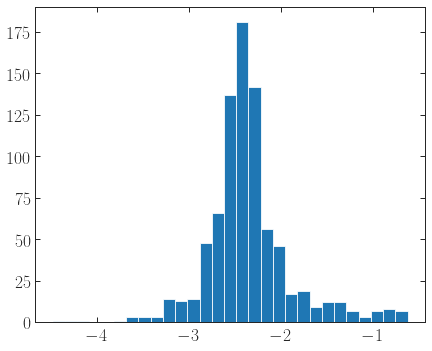

In [256]:
plot()
# so the distributions of f_nth are fairly LOGnormal aside from the zeros...
# is plotting the average of the logs and the standard deviation of the logs the right move?
plt.hist(np.log10(fnth_inds[:,10][fnth_inds[:,10] != 0]), bins='sqrt')
len(np.where(fnth_inds[:,20] == 0)[0])
len(np.where(fnth_inds[:,10] == 0)[0]) # this is a large fraction
len(np.where(fnth_inds[:,0] == 0)[0]) # huge fraction, likely the problem. the solution may be to take smaller timesteps?

Text(0.5, 1.0, '$10^{13}$ $M_\\odot/h$ at $z=0$')

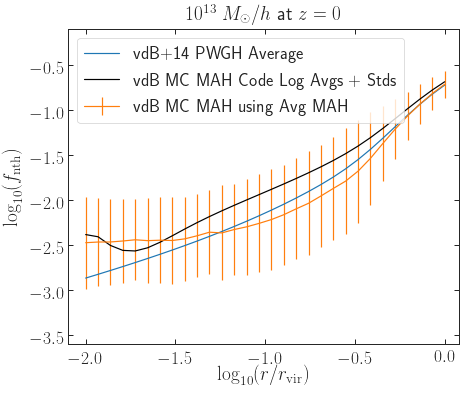

In [261]:
fig, ax = plot()
ax.set_ylim(np.log10(2.5e-4),np.log10(0.8))
ax.set_xlim(np.log10(0.8*1e-2),np.log10(1*1.2))

mass = 10**13
zed = 0.0
cosmo = cosmology.setCosmology('planck18')
fnth, rads, _, _ = gen_fnth(mass, zed, cosmo, mah_retriever=vdb_mah, mass_def='vir', conc_model='vdb', beta=beta_def, eta=eta_def)
ax.plot(np.log10(rads/rads[-1]), np.log10(fnth), label=r'vdB+14 PWGH Average')
mds = np.median(fnth_inds, axis=0)
quant16 = mds - np.percentile(fnth_inds, 16, axis=0)
quant84 = np.percentile(fnth_inds, 84, axis=0) - mds

fnth_avgs = np.zeros(len(rads))
fnth_stds = np.zeros(len(rads))

for i in range(0,len(rads)):
    fnth_avgs[i] = np.mean(np.log10(fnth_inds[:,i][fnth_inds[:,i] != 0]))
    fnth_stds[i] = np.std(np.log10(fnth_inds[:,i][fnth_inds[:,i] != 0]))
    
# we're taking the average of the logs and the std dev of the logs, since they are log normally distributed
# now, we can divide by sqrt(N)
    
#ax.errorbar(rads/rads[-1], np.median(fnth_inds, axis=0), np.array([quant16,quant84]))
#ax.plot(rads/rads[-1], fnth_quant[0,:], color='k')
#ax.plot(np.log10(rads/rads[-1]), np.log10(fnth_quant[1,:]), color='y')
#ax.plot(rads/rads[-1], fnth_quant[2,:], color='r')
#ax.errorbar(rads/rads[-1], fnth_quant[1,:], np.array([fnth_quant[1,:] - fnth_quant[0,:], fnth_quant[2,:] - fnth_quant[1,:]]))
ax.errorbar(np.log10(rads/rads[-1]), fnth_avgs, fnth_stds, label=r'vdB MC MAH using Avg MAH')
ax.plot(np.log10(rads/rads[-1]), np.log10(fnth_avg[1,:]), color='k', label=r'vdB MC MAH Code Log Avgs + Stds')
ax.set_xlabel(r'$\log_{10}(r/r_\mathrm{vir})$')
ax.set_ylabel(r'$\log_{10}(f_\mathrm{nth})$')
ax.legend()
ax.set_title(r'$10^{13}$ $M_\odot/h$ at $z=0$')

# we want to overplot on this the MAH using the new approach

# this should look exactly like Frank's I think... maybe not?

# this seems to agree pretty well with Frank's PWGH code here down to small logr, but then it blows up
# this is probably because we aren't accounting for a large fraction of f_nth values that are zero

In [ ]:
# next step: look at the Compton y for Planck18 cosmology, use to plot completeness

def p_2_y(r,p,ind):
    '''
    Discrete Integration for y, calculate \int P dl, l=np.sqrt(r3d^2-r2d^2).
    If P is in unit of P200m, r in unit of R200m, y is in unit of P200m*R200m.
    r is 3D radius (r3d), P is pressure, ind is index of 2D radius array (r2d) you want y value for.
    Assume 2D radius array is same as 3D radius. Assume equal log space.
    '''
    dlogr = np.log(r[2]/r[1])
    return np.sum(p[ind+1:]*r[ind+1:]**2*dlogr/np.sqrt(r[ind+1:]**2-r[ind]**2))

In [ ]:
# current to-do list:
# 1. Code up Ludlow16 concentration model and see how different the results are
# 2. Run the analysis for Planck 18, M=13, z=0 using the individual MAHs and compare to PWGH
# 3. Confirm whether or not the result for individual haloes agrees with the mean + std dev or median + 16/84
# ---> Ask Frank about this... why such large standard deviation? Strange shape probably... this doesn't look good
# ---> Can get results fairly consistent with PWGH for averages when we use averages of the logs and throw out the zeros
#      at the end... need to find out if this is the right process
# 4. Decide if we should set to zero the sigma_nth whenever it goes negative or just set to zero if negative at end?
# 5. Write code that plots the 3x3 panel for Planck18, talk with Han about running for some other cosmologies?
# 6. Figure out how to get the y_SZ plots...

# let's see how different the results are:
# 1. Run the MAH and the upper/lower bounds through the pipeline
# 2. Run the individual MAHs through the pipeline and then take the std/16/84 on the individual f_nth values